# Part 2 - Region Properties


## A)


<ol type="i" style="font-size: 14px;">
<li>Develop a <strong>robust, automated</strong> and <strong>data driven</strong> code to find the largest object in a binary image (scissor2.jpg)</li>
</ol>


Through testing & visual observation, it was found that applying another "median" filter after opening and closing the image, allows for the shapes to be more clearly defined above impulse noise levels of 0.7, however it would come with the downfall that it would lose a small bit of information at lower noise levels.


C:\Users\adeli\AppData\Local\Temp\ipykernel_20940\1835272811.py:64: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  filtered_image = morphology.remove_small_holes(filtered_image)


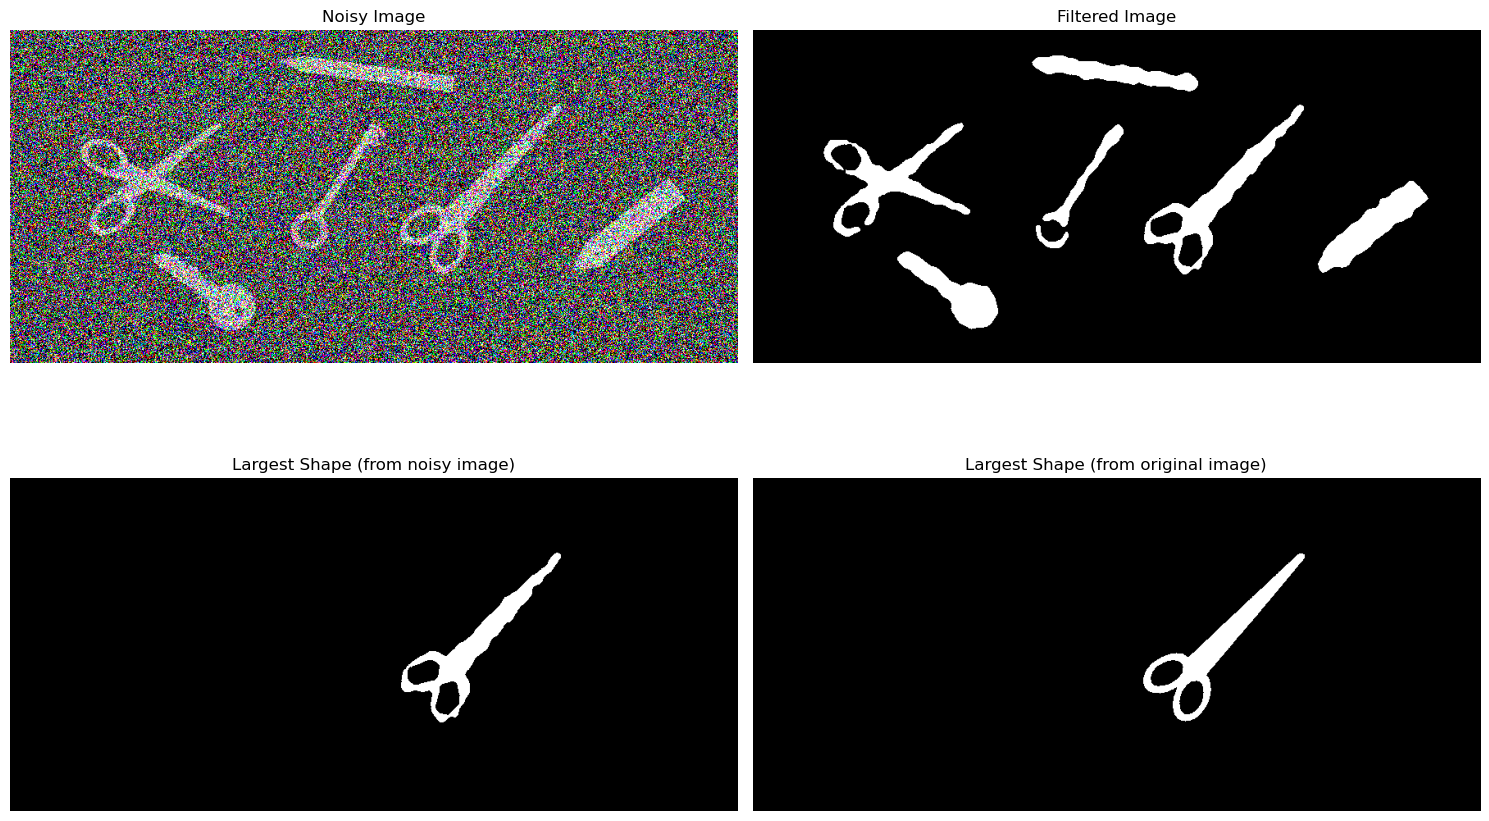

In [35]:
# import required packages
from skimage import img_as_ubyte
import skimage.io as io
import skimage.util as util
import skimage.filters as filters
import skimage.color as color
import skimage.morphology as morphology
import os
import matplotlib.pyplot as plt
import numpy as np

# set up dir
# EE425_DIR = os.path.join('C:\\', 'Users', 'adeli','Desktop','College','fourth_year','ee425-image-processing-and-analysis')
# ASSIGNMENT_DIR = os.path.join(EE425_DIR, 'ca_assignment')
ASSIGNMENT_DIR = os.getcwd()

###### STEPS / PSEUDO CODE ######
# 1. load image & convert the image to grayscale
# 2. apply median filter to remove noise with 5x5 square SE (structuring element) - 5x5 is used instead of 3x3 as it is more
# effective at removing noise with size of shapes that we are concerned with
# 3. apply morphological opening - this removes some of the noise in the background (any white spots in the background)
# 4. apply morphological closing - this removes some of the noise in the foreground (ie any black spots inside the shapes)
# NOTE: another median filter could be applied, which allows the shapes to be more noticeable/defineda at higher noise levels 
# however it removes information/edges at lower noise leves.
# 5. Finding biggest shape

def apply_filters(image: np.ndarray, apply_extra_median_filter: bool = False):
  """
  Applies filters to an image so that largest shape can be found.
  Steps:
  1. convert to grayscale
  2. apply median filter
  3. apply morphological opening
  4. apply morphological closing
  optional step - apply median filter again

  Parameters
  ----------
  `image` : np.ndarray
    Image to apply filters to
  `apply_extra_median_filter` : bool, optional
    Whether to apply an extra median filter to the image, by default False

  Returns
  -------
  `filtered_image` : np.ndarray
    Filtered image
  """
  # step 1 - convert to grayscale
  try:
    greyscale_image = color.rgb2gray(image)
  except ValueError:
    greyscale_image = image # image is already greyscale
  
  # turn into binary image
  thresh = filters.threshold_otsu(greyscale_image)
  thresh_image = img_as_ubyte(greyscale_image > thresh)

  ## step 2 - apply median filter to remove the salt and pepper noise
  filtered_image = filters.rank.median(thresh_image, morphology.square(11))
  
  # removing small artefacts
  filtered_image = morphology.remove_small_objects(filtered_image)
  filtered_image = morphology.remove_small_holes(filtered_image)

  # ### AFTER FURTHER TESTING, THESE WERE REMOVED & SIZE OF MEDIAN FILTER ABOVE CHANGED ######################
  # # step 3 - apply morphological opening to remove background white spots
  # filtered_image = morphology.binary_opening(filtered_image, morphology.square(3))
  
  # # step 4 - apply morphological closing to remove black spots in shape, and to regenerate shape of objects (eg if the outline is blobs of black and white)
  # ##### ie. to close any gaps in the shapes - 
  # ##### dilation helps with closing any breaks in the shapes too
  # filtered_image = morphology.binary_closing(filtered_image, morphology.square(3))
  # filtered_image = morphology.binary_dilation(filtered_image, morphology.square(3))
  # ###########################################################################################################
  
  # optional step - apply median filter again
  if apply_extra_median_filter:
    filtered_image = filters.rank.median(img_as_ubyte(filtered_image), morphology.square(7))

  return filtered_image
  #########################################################################################################################

def find_largest_shape(binary_image: np.ndarray):
  """
  Finds the largest shape in a binary image.

  Parameters
  ----------
  `binary_image` : np.ndarray
    Binary image to find largest shape in

  Returns
  -------
  `image_with_largest_shape` : np.ndarray
    Image with largest shape
  """
  # Label each shape in the binary image (ie. give it a different color) => the pixels with value 0 (black) are labelled
  # as background so that we can ignore that label when finding largest. This will be label 0.
  labelled_image = morphology.label(binary_image, background=0)
  
  # find the unique labels, and the number of pixels for each
  # unique_labels is the array of labels, while counts is the number of times the corresponding
  # label appears
  unique_labels, counts = np.unique(labelled_image, return_counts=True)

  # Ignore the label of the background, which is 0 based on function above
  unique_labels = unique_labels[1:]
  counts = counts[1:]
      
  # find the label with most amount of pixels
  idx_of_largest = np.argmax(counts)
  largest_shape_label = unique_labels[idx_of_largest]

  # keep only the pixels from image with label `largest_shape_label`
  # the `labelled_image == largest_shape_label` returns 0 or 1 for each pixel so output will be binary
  image_with_largest_shape = labelled_image == largest_shape_label
  
  return image_with_largest_shape

# IMAGE_NAME = 'shapes.png'
IMAGE_NAME = 'scissors2.jpg'
NOISE_AMOUNT = 0.7
original_image = io.imread(os.path.join(ASSIGNMENT_DIR, IMAGE_NAME))
noisy_image = util.random_noise(original_image, mode='s&p', amount=NOISE_AMOUNT)
filtered_image = apply_filters(noisy_image, apply_extra_median_filter=True)
largest_shape = find_largest_shape(filtered_image)

original_binary = img_as_ubyte(color.rgb2gray(original_image) > filters.threshold_otsu(color.rgb2gray(original_image)))
original_largest = find_largest_shape(original_binary)

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(15, 10))

ax[0, 0].imshow(noisy_image, cmap=plt.cm.gray)
ax[0, 0].set_title('Noisy Image')
ax[0, 0].axis('off')

ax[0, 1].imshow(filtered_image, cmap=plt.cm.gray)
ax[0, 1].set_title('Filtered Image')
ax[0, 1].axis('off')

ax[1, 0].imshow(largest_shape, cmap=plt.cm.gray)
ax[1, 0].set_title('Largest Shape (from noisy image)')
ax[1, 0].axis('off')

ax[1, 1].imshow(original_largest, cmap=plt.cm.gray)
ax[1, 1].set_title('Largest Shape (from original image)')
ax[1, 1].axis('off')

fig.tight_layout()

## B)


<ol type="i" style="font-size: 14px;">
<li>Design an experiment to illustrate robustness of final programme. At what level of impulse noise does it fail at?</li>
</ol>


Testing 1 time & displaying result of largest in figure...


C:\Users\adeli\AppData\Local\Temp\ipykernel_20940\1835272811.py:64: UserWarning: Any labeled images will be returned as a boolean array. Did you mean to use a boolean array?
  filtered_image = morphology.remove_small_holes(filtered_image)


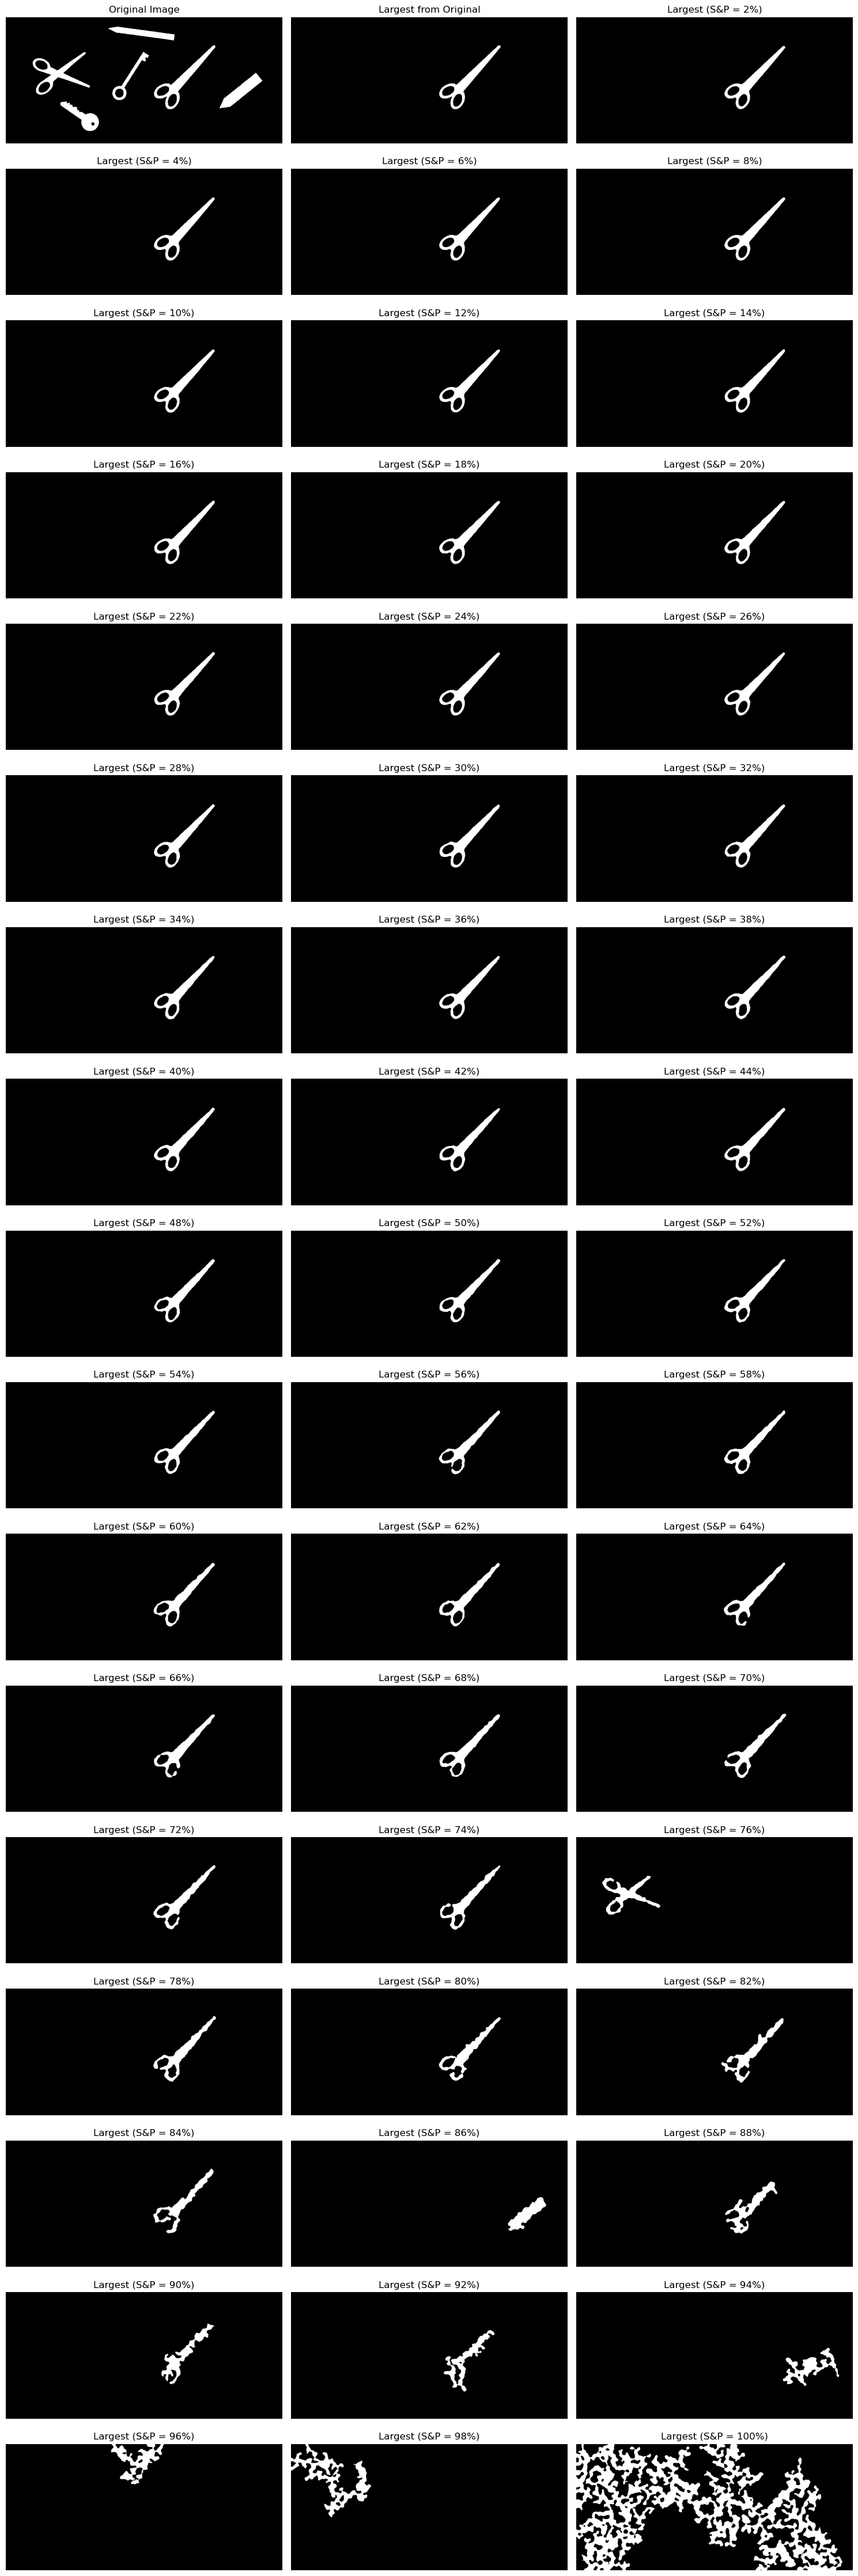

CORRECT: The percentage of pixels of the largest shape found that are in the correct place.
(In brackets is the percentage of white pixels from original image that are in the filtered image.
WRONG: The percentage of pixels that don't overlap with original.

s&p=0.2 	test=1	CORRECT: 96.88% (97.21%) 	WRONG: 3.12%
s&p=0.2 	test=2	CORRECT: 97.26% (97.27%) 	WRONG: 2.74%
s&p=0.2 	test=3	CORRECT: 96.38% (97.78%) 	WRONG: 3.62%
s&p=0.2 	test=4	CORRECT: 96.64% (96.97%) 	WRONG: 3.36%
s&p=0.2 	test=5	CORRECT: 96.36% (97.86%) 	WRONG: 3.64%
s&p=0.2 	test=6	CORRECT: 97.25% (96.69%) 	WRONG: 2.75%
s&p=0.2 	test=7	CORRECT: 96.79% (98.15%) 	WRONG: 3.21%
s&p=0.2 	test=8	CORRECT: 97.20% (97.58%) 	WRONG: 2.80%
s&p=0.2 	test=9	CORRECT: 97.25% (97.80%) 	WRONG: 2.75%
s&p=0.2 	test=10	CORRECT: 96.89% (97.56%) 	WRONG: 3.11%
s&p=0.22 	test=1	CORRECT: 96.92% (97.42%) 	WRONG: 3.08%
s&p=0.22 	test=2	CORRECT: 96.45% (97.58%) 	WRONG: 3.55%
s&p=0.22 	test=3	CORRECT: 96.68% (97.75%) 	WRONG: 3.32%
s&p=0.22 	test=4	CORREC

In [42]:
# WARNING:
# This script does a lot of computation!!! The script will take a long time
# If you don't want to fry your computer, please ensure you run the test_robustness()
# function as follows: `test_robustness(show_images=False)` so that images arent shown,
# and you just get the numerical values, or just don't run the robustness function.

# Please run previous script before running this one!

shape_image = original_binary

largest_from_original = original_largest

def test_noise_one_time():
  """
  Test original image for impulse noise levels 0.02, 0.04, 0.06... etc
  and display results on one figure
  """

  print("Testing 1 time & displaying result of largest in figure...")

  impulse_noise = 0.02
  fig, ax = plt.subplots(nrows=17, ncols=3, figsize=(15, 45))

  # first image is original
  ax[0, 0].imshow(original_image, cmap=plt.cm.gray)
  ax[0, 0].set_title('Original Image')
  ax[0, 0].axis('off')

  # second image is largest from original
  ax[0, 1].imshow(largest_from_original, cmap=plt.cm.gray)
  ax[0, 1].set_title('Largest from Original')
  ax[0, 1].axis('off')

  while impulse_noise <= 1:
    # round to remove the additional decimals
    impulse_noise = round(impulse_noise, 2)

    # apply s&p noise
    noisy = util.random_noise(shape_image, mode='s&p', amount=impulse_noise)

    # filter
    filtered = apply_filters(noisy, apply_extra_median_filter=True)

    # get largest shape
    largest = find_largest_shape(filtered)
    
    img_number = round((impulse_noise + 0.02) * 49)
    row = img_number // 3
    col = img_number % 3

    ax[row, col].imshow(largest, cmap=plt.cm.gray)
    ax[row, col].set_title(f'Largest (S&P = {round(impulse_noise * 100)}%)')
    ax[row, col].axis('off')
    
    # increment noise
    impulse_noise += 0.02

  fig.tight_layout()
  io.show()


def test_robustness(show_images: bool = False):
  """
  Test robustness of code by finding the precentage of right pixels, and 
  percentage of wrong pixels, and using these to determine if the result is
  good enough to be considered correct.
  """
  number_of_tests_at_each_impulse = 10
  first_fail = 1 # default val
  number_of_mistakes = 0
  number_of_tests = 0

  # at what value of impulse noise to start/end testing!
  impulse_noise = 0.2
  max_impulse_noise = 1

  if not os.path.exists('q2_tests'):
    os.makedirs('q2_tests')

  print("CORRECT: The percentage of pixels of the largest shape found that are in the correct place.\n(In brackets is the percentage of white pixels from original image that are in the filtered image.")
  print("WRONG: The percentage of pixels that don't overlap with original.\n")
  while impulse_noise <= max_impulse_noise:
    impulse_noise = round(impulse_noise, 2)
    
    fig, ax = plt.subplots(nrows=2, ncols=number_of_tests_at_each_impulse, figsize=(100, 10)) if show_images else (None, None)

    # test each percent 10 times
    for test_number in range(1, number_of_tests_at_each_impulse + 1):
      number_of_tests += 1
      noisy = util.random_noise(shape_image, mode='s&p', amount=impulse_noise)
      filtered = apply_filters(noisy, apply_extra_median_filter=True)
      largest = find_largest_shape(filtered)
      
      if show_images:
        # Showing images of results:
        # row 0 = noisy image
        # row 1 = filtered image showing only largest shape found
        idx = test_number - 1
        ax[0, idx].set_title(f"Test #{test_number}")
        ax[0, idx].imshow(noisy, cmap=plt.cm.gray)
        ax[0, idx].axis('off')

        ax[1, idx].imshow(largest, cmap=plt.cm.gray)
        ax[1, idx].axis('off')

      # Numerical results
      # below is an XOR gate, this will allow me to get the pixels that are white in
      # the filtered image, but not in original (so i can see the amount/percent of)
      # pixels added in by my filter 
      white_pixels_outside_shape = (np.logical_not(largest_from_original).astype(int)) * largest
      # AND gate to get pixels that are in both shapes
      overlapping_pixels = largest_from_original * largest

      percent_pixels_correct = (np.sum(overlapping_pixels) / np.sum(largest)) * 100
      percent_pixels_of_original_present = (np.sum(overlapping_pixels) / np.sum(largest_from_original)) * 100
      percent_pixels_wrong = (np.sum(white_pixels_outside_shape) / np.sum(largest)) * 100

      # could be changed to checking the percentage of pixels of original
      # that are present, & the percent that are wrong
      if percent_pixels_correct < 70:
        if impulse_noise < first_fail: first_fail = impulse_noise
        number_of_mistakes += 1
        
      print(f"s&p={impulse_noise} \ttest={test_number}\tCORRECT: {percent_pixels_correct:0.2f}% ({percent_pixels_of_original_present:0.2f}%) \tWRONG: {percent_pixels_wrong:0.2f}%")

    if show_images:
      fig.tight_layout()
      fig.savefig(os.path.join('q2_tests', f'test_impulse_{round(impulse_noise * 100)}_percent.png'))
      print(f"Showing images for impulse={round(impulse_noise, 2)}...")
      io.show() # show current image
    impulse_noise += 0.02
    print("================================================================================================")
  print(f"First fail at impulse noise of {first_fail*100}%")
  print(f"{number_of_mistakes} images were incorrect when testing ({number_of_tests} tests)")


## UNCOMENT THE FUNCTIONS BELOW IF YOU WANT TO RUN
## GITHUB NOT LETTING ME UPLOAD FILES > 100MB, SO HAD
## TO REMOVE OUTPUT
# This will test each noise level once from 0.02 to 1 in steps on 0.02
# test_noise_one_time()

# This will do a thorough test (10 times on each image) to ensure consistency
# test_robustness(show_images=True)